## Utilizamos un modelo preentrenado speechBrain para identificar quien está hablando

Como caracteristicas extraemos embbedings de voz y creamos el dataset

In [10]:
import os
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import numpy as np
import pandas as pd

# Configuración
input_folder = "/content/drive/MyDrive/met3norm16"
output_csv = "/content/drive/MyDrive/met3norm16/embeddings_metodo3.csv"
device = "cuda" if torch.cuda.is_available() else "cpu"


classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb",
    run_opts={"device": device}
)


def extract_embedding(input_path):

    signal, sr = torchaudio.load(input_path)


    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        signal = resampler(signal)


    with torch.no_grad():
        embeddings = classifier.encode_batch(signal)
        embedding = embeddings.squeeze().cpu().numpy()

    return embedding


X = []
y = []


for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):

        input_path = os.path.join(input_folder, filename)
        embedding = extract_embedding(input_path)
        X.append(embedding)


        label = filename.split("-")[0]
        y.append(label)


df = pd.DataFrame(X)
df["Label"] = y
df.to_csv(output_csv, index=False)

print(f"Embeddings guardados en: {output_csv}")

<ipython-input-10-5e1fe208c451>:4: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

Embeddings guardados en: /content/drive/MyDrive/met3norm16/embeddings_metodo3.csv


In [20]:
import pandas as pd

csv_path = "/content/drive/MyDrive/met3norm16/embeddings_metodo3.csv"
df = pd.read_csv(csv_path)

print(df.head())

           0          1          2          3          4          5  \
0   9.336179  32.801098  24.183523  20.152740 -21.778970  -8.701126   
1   6.428581   8.023315 -62.810740 -16.045963 -13.308585 -13.319246   
2 -21.621887  -2.577225  -2.955219   4.102473 -16.933470 -26.804575   
3   1.234451   2.599364  -6.941911 -18.405937   4.243839   2.575846   
4   8.038629  12.412204 -59.731144 -10.668978 -13.867699  -8.767658   

           6          7          8          9  ...        183        184  \
0  10.335824  40.377422 -24.052767  -8.957267  ...   6.613370   2.993681   
1  42.467854 -43.927647  42.914654  -0.016817  ...  22.506931   4.804777   
2   1.138253 -14.863340  17.812695  12.117516  ...  19.759820 -33.098310   
3   8.334475 -21.608078  11.343484  24.017117  ...  14.686467   8.559169   
4  41.138210 -40.808600  41.872710   2.553547  ...  20.200806   7.236081   

         185        186        187         188        189        190  \
0  10.079129 -10.159389   5.244230    7.2328

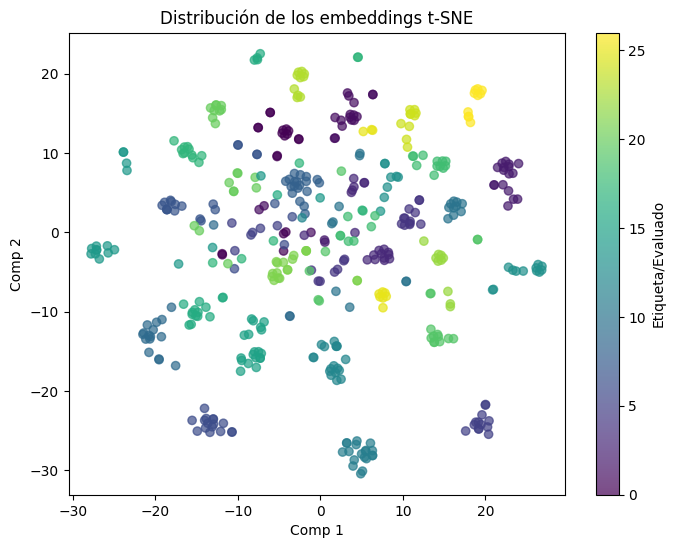

In [24]:
from sklearn.manifold import TSNE

# Extraer los embeddings (sin la columna 'Label')
X = df.drop(columns=["Label"])

# Aplicar t-SNE para reducir la dimensionalidad a 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Label'].astype('category').cat.codes, cmap='viridis', alpha=0.7)
plt.title("Distribución de los embeddings t-SNE")
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.colorbar(label="Etiqueta/Evaluado")
plt.show()



In [11]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


csv_path = "/content/drive/MyDrive/met3norm16/embeddings_metodo3.csv"
df = pd.read_csv(csv_path)


X = df.drop(columns=["Label"])
y = df["Label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVM: {accuracy * 100:.2f}%")


print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo SVM: 90.43%

Reporte de Clasificación:
                   precision    recall  f1-score   support

    AndresCalzada       1.00      1.00      1.00         3
           Ariana       1.00      0.67      0.80         3
           Camila       1.00      1.00      1.00         6
            Cielo       1.00      0.83      0.91         6
           DafneA       0.50      1.00      0.67         2
           Daniel       1.00      1.00      1.00         2
          Daniel2       1.00      0.75      0.86         4
            David       0.86      1.00      0.92         6
           Didier       1.00      1.00      1.00         2
             Erik       1.00      0.83      0.91         6
           Esther       0.80      0.80      0.80         5
        Francisco       1.00      1.00      1.00         6
          Ignacio       1.00      1.00      1.00         3
             Irma       1.00      0.50      0.67         2
     JesusAntonio       0.67      1.00      0.80      

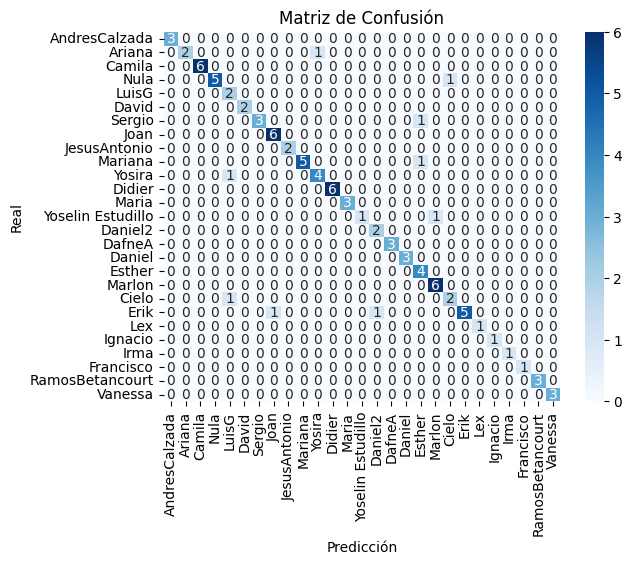

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## Guardamos el modelo ya entrenado para prueba

In [13]:
import joblib

modelo_guardado_path = "/content/drive/MyDrive/metod3PretrainedSpeechBrain.pkl"
joblib.dump(svm_model, modelo_guardado_path)

print(f"Modelo guardado en: {modelo_guardado_path}")

Modelo guardado en: /content/drive/MyDrive/metod3PretrainedSpeechBrain.pkl


# Subir la ruta del audio a poner a prueba

In [32]:
from pydub import AudioSegment
from pydub.playback import play
import os


audio_filename = "/content/drive/MyDrive/AudioTest/testLuisAndres.wav"


os.system("arecord -d 5 -f cd -t wav -r 16000 " + audio_filename)
#Cargamos el archivo
audio = AudioSegment.from_wav(audio_filename)


play(audio)


### Sacamos lo embbedings del audio grabado para probar sobre el modelo

In [33]:
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier


device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb",
    run_opts={"device": device}
)


def extract_embedding(input_path):
    signal, sr = torchaudio.load(input_path)


    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        signal = resampler(signal)


    with torch.no_grad():
        embeddings = classifier.encode_batch(signal)
        embedding = embeddings.squeeze().cpu().numpy()

    return embedding


embedding = extract_embedding(audio_filename)


/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device